# Clustering Prototype - Initial Version
## Sentence embedding, dimensionality reduction, feature selection, clustering, and explaining clusters.

---

This file will allow you to set variables to run clustering and explainability on a dataset. In the next cell, you will be able to:

1.   Specify a dataset. The dataset must be in .csv format and must have at least one textual column. For the feature selection option, the dataset must have a categorical label column.
     - [IMDB Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) for sentiment analysis
     - [Customer Support Ticket Dataset](https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset)
2.   Specify an embedding method
     - Sentence-BERT ([paper](https://arxiv.org/abs/1908.10084), [documentation](https://www.sbert.net/))
     - LLM2Vec ([paper](https://arxiv.org/abs/2404.05961), [GitHub](https://github.com/McGill-NLP/llm2vec))
2.   Flag if you would like dimensionality reduction (PCA) to occur
3.   Flag if you would like feature selection (decision trees) to occur

Based on these options, the file will run K-means clustering and labeling on the dataset.

Finally, it will prompt an LLM to explain the cluster groupings.

---


## Set options for clustering

For each of the sections in the following cell, uncomment the option you wish to use for each section and ensure the rest are commented out. You can also proceed with default values and later come back and modify them.

- For dataset selection:
  - Uncomment the dataset you would like to use, and specify a text_col (the column name to perform clustering on)
  - If you wish to do feature selection (decision trees): specify a label_col as well (the column name to make predictions on)
  - Optionally: provide a custom dataset by uploading a .csv file in this repository, and specify a text_col and optionally a label_col as described above

- For embedding methods, the options are:
  - Sentence BERT
  - LLM2Vec

- For dimensionality reduction, you can:
  - Enable PCA and provide a number of dimensions for PCA
  - Or, disable PCA.

- For feature selection, you can:
  - Enable decision trees and provide a feature importance threshold  (minimum importance threshold for selection) as well as a test train ratio (for training decision trees)
  - Or, disable decision trees.

- For cluster count, you can specify:
  - A method of scoring (WCSS Elbow or SIlhouette Score)

In [ ]:
# Dataset selection -----------------------------------
dataset_sample_ratio = 1 # percentage of dataset to actually look at

# --- Movie reviews ---
# dataset = "IMDB.csv"
# text_col = "review"
# label_col = "sentiment"

# --- Customer tickets ---
# dataset = "helpdesk_customer_tickets.csv"
# text_col =
# label_col =

# --- Synthetic customer conversation with chatbot ---
# dataset = "Synthetic_Customer_Data.csv"
# text_col = "Conversation"


# Embedding method -----------------------------------
method = "s_bert"
# method = "llm2vec"

# Dimensionality reduction (PCA) ---------------------
# pca = False
pca = True
pca_dimensions = 10

# Feature selection (decision trees)  ----------------
# decision_trees = False
# decision_trees = True
feature_importance_threshold  = 0.025 # minimum importance threshold for selection
test_train_ratio = 0.3 # test train ratio for training decision trees

# Cluster count selection ----------------------------
cluster_count_method = "WCSS Elbow"
# cluster_count_method = "Silhouette Score"

# Analysis and miscellaneous -------------------------
cluster_sample_count = 5 # how many datapoint samples per cluster to display at the end


## Imports and Requirements

This notebook was ran on a newly created venv through conda in order to gather the necessary requiremets. The venv was running Python 3.11.10.

---

The necesary installs will be dependent on what is present in your environment, however, these installs will be necessary if you are running on a fresh environment:

In [ ]:
!pip install transformers

!pip install torch

!pip install -U sentence-transformers

!pip install matplotlib

!pip install numpy==1.26
# Note: Numpy versions above 2 cause issues with the notebook

!pip install pandas

In [94]:
%pip install -r requirements.txt #DO NOT RUN FOR NOW - dependency conflict

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#DO'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Kerria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

!env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True # Allow torch to allocate memory more effectively

'env' is not recognized as an internal or external command,
operable program or batch file.


### LLM2Vec additional requirement: Request model access

If you plan to use LLM2Vec, you need to create a HuggingFace account and [access token](https://huggingface.co/settings/tokens) (a read-level token should suffice). Then, request access to model, which is currently under gated repo access: [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)

In [ ]:
if method == "llm2vec":
  !pip install llm2vec -q
  !huggingface-cli login

  from llm2vec import LLM2Vec
  import torch
  from transformers import AutoTokenizer, AutoModel, AutoConfig
  from peft import PeftModel

In [98]:
# Read dataset --------------------------------------------------------------
df = pd.read_csv(dataset)
df = df.sample(frac=dataset_sample_ratio)
text = df[text_col]

In [99]:
# Calculate embeddings ------------------------------------------------------
# Note: this is a time-consuming step (~7 min)
if method == "s_bert":
  embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
  embeddings = embedding_model.encode(text.tolist(), convert_to_tensor=False)
elif method == "llm2vec":
  # Following code adapted from https://huggingface.co/McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp-supervised
  tokenizer = AutoTokenizer.from_pretrained(
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp"
  )
  config = AutoConfig.from_pretrained(
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp", trust_remote_code=True
  )
  model = AutoModel.from_pretrained(
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp",
      trust_remote_code=True,
      config=config,
      torch_dtype=torch.bfloat16,
      device_map="cuda" if torch.cuda.is_available() else "cpu",
  )
  model = PeftModel.from_pretrained(
      model,
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp",
  )
  model = model.merge_and_unload()  # This can take several minutes on CPU

  # Loading supervised model. This loads the trained LoRA weights on top of MNTP model. Hence the final weights are -- Base model + MNTP (LoRA) + supervised (LoRA).
  model = PeftModel.from_pretrained(
      model, "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp-supervised"
  )

  # Wrapper for encoding and pooling operations
  l2v = LLM2Vec(model, tokenizer, pooling_mode="mean", max_length=512)

  embeddings = l2v.encode(text.tolist())

C:\Users\Kerria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


If PCA is selected, we will display a scree plot of possible component numbers with an option to switch the pca_dimension count if needed.

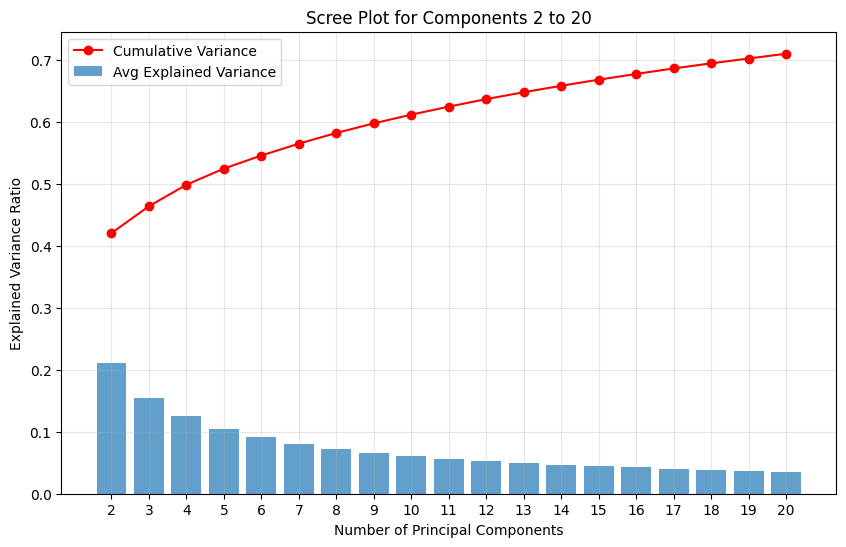

In [100]:
# Dimensionality Reduction (PCA) --------------------------------------------
PCA_MAX_DIMENSION = 21
if pca:
  n_components = range(2, PCA_MAX_DIMENSION) # range of testing

  # Perform PCA for each number of components and store explained variance
  explained_variance_ratios = []
  cumulative_variance_ratios = []

  for n in n_components:
      pca = PCA(n_components=n)
      pca.fit(embeddings)
      explained_variance_ratios.append(pca.explained_variance_ratio_)
      cumulative_variance_ratios.append(np.cumsum(pca.explained_variance_ratio_))

  # Average explained variance ratio over the number of components
  avg_explained_variance_ratio = [np.mean(ratio) for ratio in explained_variance_ratios]

  # Plot the Scree Plot
  plt.figure(figsize=(10, 6))
  plt.bar(n_components, avg_explained_variance_ratio, alpha=0.7, label='Avg Explained Variance')
  plt.plot(n_components, [cum[-1] for cum in cumulative_variance_ratios], label='Cumulative Variance', color='red', marker='o')

  # Add titles and labels
  plt.title('Scree Plot for Components 2 to 20')
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Explained Variance Ratio')
  plt.xticks(n_components)
  plt.legend(loc='best')
  plt.grid(alpha=0.3)
  plt.show()


In [101]:
if pca:
  pca_model = PCA(n_components=pca_dimensions)
  embeddings = pca_model.fit_transform(embeddings)

## Incorporate feature selection using decision trees

"Shrink" or drop the non-important features with respect to the output class, and "expand" the features that are more important to determining the output class.

In [102]:
# Feature Selection (Decision Trees) ----------------------------------------
if decision_trees:
  X_train, X_test, y_train, y_test = train_test_split(embeddings, df[label_col], random_state = 8, test_size = test_train_ratio)

  # Fit the decision tree model
  decision_tree_model = DecisionTreeClassifier()
  decision_tree_model.fit(X_train, y_train)

  # Access feature importances
  feature_importances = decision_tree_model.feature_importances_

  # Delete low-importance features
  low_importance_indices = np.where(feature_importances < feature_importance_threshold)[0] # random sampling prob. -- 1/384 = 0.0026
  embeddings_small = np.delete(embeddings, low_importance_indices, axis=1)
  X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)
  X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)
  print(f"Embeddings went from size {len(X_train[0])} to {len(X_train_reduced[0])}")
else:
  embeddings_small = embeddings # because regardless of whether feature selection is performed the next section uses embeddings_small

## K-means clustering

First determine optimal number of clusters through either WCSS elbow point selection or silhouette score maximization.

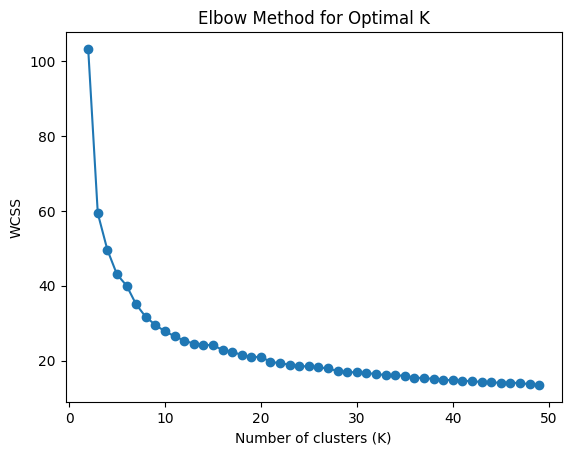

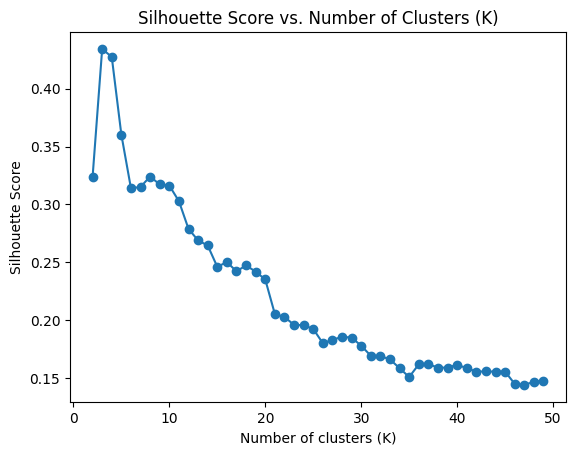

In [103]:
wcss_list = []  # within-cluster sum of squares
silhouette_scores_list = []

# Calculate WCSS for each K
upper_bound_k = 50
for k in range(2, min(upper_bound_k, embeddings_small.shape[0])):  # Choosing range from 1 to 50 for demonstration
    # wcss
    kmeans_experiment = KMeans(n_clusters=k, random_state=0)
    kmeans_experiment.fit(embeddings_small)
    wcss_list.append(kmeans_experiment.inertia_)

    labels = kmeans_experiment.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores_list.append(score)

# Plot the WCSS values
plt.plot(range(2, min(upper_bound_k, embeddings_small.shape[0])), wcss_list, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, min(upper_bound_k, embeddings_small.shape[0])), silhouette_scores_list, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

Determine optimal k. Either maximize Silhouette Score or estimate elbow point of WCSS chart.

In [104]:
if cluster_count_method == "Silhouette Score":
    max_index = np.argmax(silhouette_scores_list)
    num_clusters = max_index + 2 # index 0 corresponds to 2 clusters
elif cluster_count_method == "WCSS Elbow":
    # elbow point occurs as the first point whose slope with the previous point is less than 1
    i = 1
    while i < len(wcss_list) and abs(wcss_list[i-1]-wcss_list[i]) > 1:
            i += 1
    num_clusters = i # index 0 corresponds to neighbor_range + 1 clusters



else:
    if isinstance(cluster_count_method, int):
        num_clusters = cluster_count_method
    else:
        print("ERROR: must choose valid cluster_count_method")


# Perform K-means clustering
# num_clusters = 5  # Define the number of clusters you want
print(f"Chosen number of clusters: {num_clusters}\ncluster_count_method: {cluster_count_method}")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_small)

# Print WCCS (within-cluster sum of squares) metric
wcss = kmeans.inertia_
print("Within-Cluster Sum of Squares:", wcss)

Chosen number of clusters: 4
cluster_count_method: 4
Within-Cluster Sum of Squares: 49.59883499145508


## Find closest examples to cluster centroids

Currently, we are using cosine similarity to find the data point closest to the cluster centroids as a proxy for explaining or representing that cluster. We can also explore other ways (e.g. using LLMs) to explain clusters.

In [105]:
# For each cluster centroid, print the closest data point
corpus = list(df[text_col])
centroid_embeddings = kmeans.cluster_centers_
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings_small)
    closest_data_point = corpus[int(similarity_scores.argmax())]
    print(f"Centroid of cluster {i}:\n-----\n{closest_data_point}\n-----\n\n")

Centroid of cluster 0:
-----
bot: Hi Emily, welcome to LightWave Internet Support. How can I help you today? ::: customer: My internet's been out for 48 hours and I didn't get any notice or updates. This is ridiculous! ::: bot: I'm very sorry to hear that. I understand how frustrating that must be. Let me look into this for you. ::: customer: Please do, I need this fixed asap. I'm missing work because of this. ::: bot: I apologize for the inconvenience. Let me verify your account information. Could you please provide your account number or registered phone number? ::: customer: Sure, it's 1234567890. ::: bot: Thank you, Emily. I see that there's a known outage in your area due to maintenance. It should have been communicated. ::: customer: Well it wasn’t! When is it going to be fixed? ::: bot: I understand your frustration. The estimated time for the service to be restored is in the next 4 hours. ::: customer: Four more hours?? This is killing me. Can't you do something faster? ::: bot

In [106]:
# Print a few data points from each cluster to also help with explainability
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster'] == i][text_col].tolist()[:cluster_sample_count]
    for s in samples:
        print("--")
        print(s)
    print("--")




Cluster 0:
--
bot: Hi Emma, Welcome to StreamJoy Support. How can I help you today? ::: customer: I'm being charged for movies I never rented. Please fix this. ::: bot: I'm sorry to hear about this issue, Emma. Let me take a look at your account. One moment, please. ::: customer: Ok but hurry pls ::: bot: Thank you for your patience. I see a few recent charges for movie rentals. Can you confirm if you did not authorize these rentals? ::: customer: Yeah I didn't rent any movies recently. ::: bot: I apologize for the inconvenience. Let's get this sorted. I'll initiate a refund for the unauthorized charges. This should appear in your account within 5-7 business days. ::: customer: Okay thanks. Will this stop future charges too? ::: bot: Yes, I am also updating your account settings to prevent any unauthorized rentals in the future. ::: customer: Good. Anything else I need to do? ::: bot: No, I've taken care of everything on our end. You should not see any more unauthorized charges. If 